## **DDPG Implementation with Pytorch**

In [3]:
import gymnasium as gym

import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from collections import deque
import random

import os
import matplotlib.pyplot as plt
from tqdm import tqdm

In [ ]:
ENV_NAME = "Pendulum-v1"
env = gym.make(ENV_NAME)

In [ ]:
print(env.action_space.shape)
print(env.observation_space.shape)

(1,)
(3,)


In [4]:
def list_to_tensor(l):
  return torch.from_numpy(np.array(l)).to(torch.float32)

In [12]:
class Actor(nn.Module):  # deterministic policy
  def __init__(self):
    super(Actor, self).__init__()

    self.layers = nn.ModuleList([])
    self.layers.append(nn.Linear(3, 128))
    self.layers.append(nn.Linear(128, 64))
    self.layers.append(nn.Linear(64, 32))
    self.layers.append(nn.Linear(32, 1))

  def forward(self, x):
    for layer in self.layers:
      x = F.gelu(layer(x))
    x = torch.clamp(x, -2.0, 2.0)
    return x # action

class Critic(nn.Module):  # approximates Q(s_t, a_t)
  def __init__(self):
    super(Critic, self).__init__()

    self.layer_state1 = nn.Linear(3, 128)
    self.layer_state2 = nn.Linear(128, 64)
    self.layer_action = nn.Linear(1, 64)
    self.layers = nn.ModuleList([nn.Linear(128, 64), nn.Linear(64, 32), nn.Linear(32, 1)])

  def forward(self, state, action):
    state = F.gelu(self.layer_state1(state))
    state = F.gelu(self.layer_state2(state))
    action = F.gelu(self.layer_action(action))
    z = torch.cat([state, action], dim = -1)
    for layer in self.layers:
      z = F.gelu(layer(z))
    return z

In [32]:
class DDPGAgent():
  def __init__(self,
               env_name = "Pendulum-v1",
               discount_factor = 0.99,
               memory_size = 10000,
               batch_size = 32,
               actor_learning_rate = 0.0001,
               critic_learning_rate = 0.001,
               tau = 0.001):

    self.GAMMA = discount_factor
    self.MEMORY_SIZE = memory_size
    self.BATCH_SIZE = batch_size
    self.ACTOR_LR = actor_learning_rate
    self.CRITIC_LR = critic_learning_rate
    self.TAU = tau

    self.env = gym.make(env_name)
    self.action_dim = self.env.action_space.shape[0]
    self.state_dim = self.env.observation_space.shape[0]

    self.actor = Actor()
    self.target_actor = Actor()
    self.critic = Critic()
    self.target_critic = Critic()
    self.optim_actor = optim.Adam(self.actor.parameters(), lr = self.ACTOR_LR)
    self.optim_critic = optim.Adam(self.critic.parameters(), lr = self.CRITIC_LR)

    self.memory = deque(maxlen = self.MEMORY_SIZE)

    self.update_target_network(1.0)

  def update_target_network(self, tau):
    for target_param, param in zip(self.target_actor.parameters(), self.actor.parameters()):
      target_param.data.copy_(tau * param.data + (1.0 - tau) * target_param.data)

    for target_param, param in zip(self.target_critic.parameters(), self.critic.parameters()):
      target_param.data.copy_(tau * param.data + (1.0 - tau) * target_param.data)

  def ou_noise(self, x, rho = 0.15, mu = 0, sigma = 0.2, dt = 0.1, dim = 1):
    return x + rho * (mu - x) * dt + sigma * np.sqrt(dt) * np.random.normal(size = dim)

  def td_target(self, reward, q_values, dones):
    td_targets= np.asarray(q_values)
    for i in range(td_targets.shape[0]):
      if dones[i]:
        td_targets[i] = reward[i]
      else:
        td_targets[i] = reward[i] + self.GAMMA * q_values[i] ## Q(s_t+1, a_t+1)
    return td_targets

  def sample_from_memory(self):
    batch = random.sample(self.memory, self.BATCH_SIZE)
    states, actions, rewards, next_states, dones = zip(*batch)
    return states, actions, rewards, next_states, dones

  def critic_learn(self, states, actions, td_targets):
    self.optim_critic.zero_grad()
    # TRACK COMPUTATIONS
    batch_states = torch.stack(states)
    batch_actions = torch.stack(actions)
    batch_td_targets = torch.tensor(td_targets, dtype = torch.float32)
    q_values = self.critic(batch_states, batch_actions)

    critic_loss = F.mse_loss(q_values, batch_td_targets)
    critic_loss.backward()
    self.optim_critic.step()
    return critic_loss.item()

  def actor_learn(self, states):
    self.optim_actor.zero_grad()
    # TRACK COMPUTATIONS
    states = torch.stack(states)
    actions = self.actor(states)
    q_values = self.critic(states, actions)
    actor_loss = -torch.mean(q_values)

    actor_loss.backward()
    self.optim_actor.step()
    return actor_loss.item()

  def train(self, num_episodes):

    self.actor.train()
    self.critic.train()

    self.actor_losses = []
    self.critic_losses = []
    self.episode_rewards = []

    pbar = tqdm(range(num_episodes), desc = "Training process")
    for ep in pbar:
      state, _ = self.env.reset()
      state = torch.tensor(state, dtype=torch.float32)

      pre_noise = np.zeros(self.action_dim)
      episode_reward = 0
      done = False

      while not done:
        with torch.no_grad():
          action = self.actor(state)
        noise = self.ou_noise(pre_noise, dim = self.action_dim)
        action = action + torch.tensor(noise, dtype=torch.float32)

        next_state, reward, terminated, truncated, _ =  self.env.step(action.detach().numpy())
        done = terminated or truncated

        # Collect samples
        reward = (reward + 8) / 8
        next_state = torch.tensor(next_state, dtype = torch.float32)
        self.memory.append((state, action, reward, next_state, done)) # Tensor, Tensor, ndarray, Tensor , boolean

        # Sample & Update
        if len(self.memory) >= 500:
          batch_state, batch_action, batch_reward, batch_next_state, batch_dones = self.sample_from_memory()
          batch_next_state = torch.stack(batch_next_state)
          with torch.no_grad():
            target_qs = self.target_critic(batch_next_state, self.target_actor(batch_next_state))
          td_targets = self.td_target(batch_reward, target_qs.numpy(), batch_dones)

          self.critic_learn(batch_state, batch_action, td_targets)
          self.actor_learn(batch_state)
          self.update_target_network(self.TAU)

        # Prepare next step
        pre_noise = noise
        state = next_state
        episode_reward += reward

      pbar.set_postfix({"Episode Reward" : episode_reward})
      pbar.update(1)

      self.episode_rewards.append(episode_reward)

In [33]:
agent = DDPGAgent()
agent.train(num_episodes=400)

Training process: 100%|██████████| 400/400 [12:10<00:00,  1.83s/it, Episode Reward=170]


In [48]:
def calculate_ema(data, alpha):
    ema_values = []
    ema = data[0]
    ema_values.append(ema)

    for price in data[1:]:
        ema = alpha * price + (1 - alpha) * ema
        ema_values.append(ema)

    return ema_values

ema_values = calculate_ema(agent.episode_rewards, 0.1)

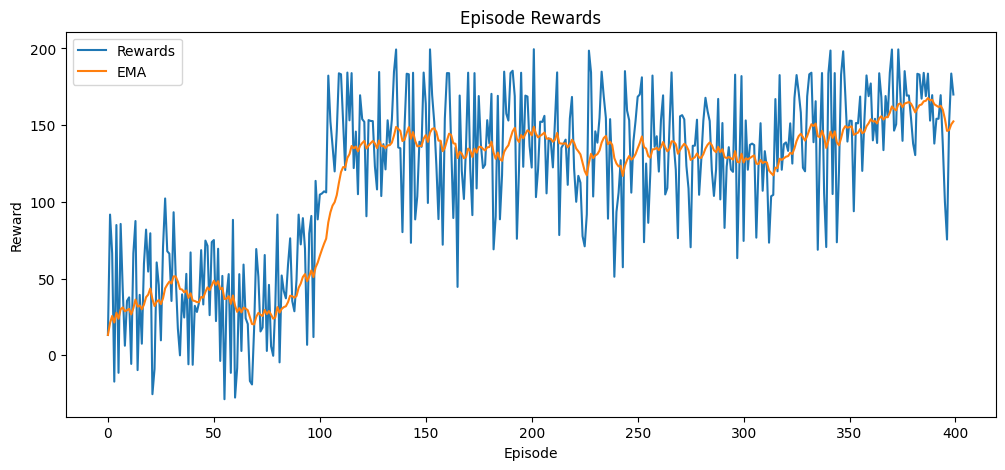

In [49]:
# 그래프 그리기
plt.figure(figsize=(12, 5))

# 에피소드별 보상
plt.plot(agent.episode_rewards, label='Rewards')
plt.plot(ema_values, label='EMA')
plt.title("Episode Rewards")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()

## **Evaluation**

Episode : 1, Reward : 184.2998787686788
Episode : 2, Reward : 199.3423360351398
Episode : 3, Reward : 170.04431881776415
Episode : 4, Reward : 184.59302229753675
Episode : 5, Reward : 155.47490718893891


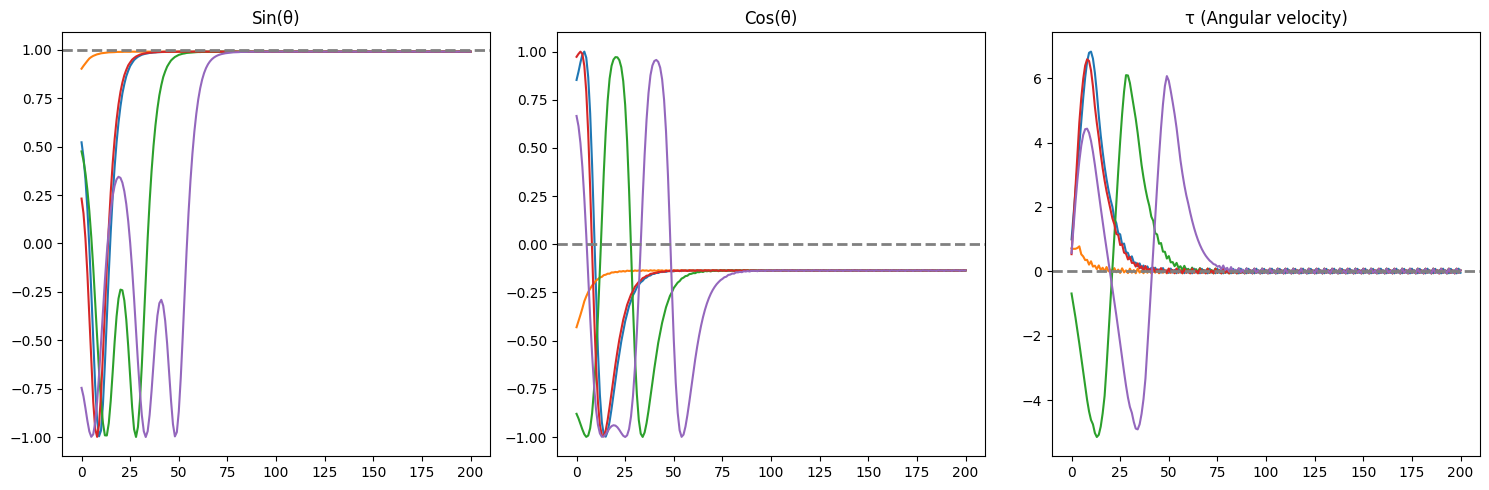

In [55]:
# Evaluate

from gymnasium.wrappers import RecordVideo
from IPython.display import Video

@torch.no_grad()
def evaluate(agent, num_episodes = 5):

    video_folder = "./videos/"
    os.makedirs(video_folder, exist_ok=True)
    env = RecordVideo(gym.make("Pendulum-v1", render_mode="rgb_array"), video_folder=video_folder, episode_trigger=lambda x: True)
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    for ep in range(num_episodes):
        state, _ = env.reset()
        state = torch.from_numpy(state)

        done = False
        total_reward = 0
        cos_list = [state[0]]
        sin_list  = [state[1]]
        tau_list = [state[2]]

        while not done:
            action= agent.actor(state)
            action = action.numpy()
            next_state, reward, terminated, truncated, _ =  env.step(action)
            reward = (reward + 8) / 8
            done = terminated or truncated
            total_reward += reward

            state = torch.from_numpy(next_state)
            cos_list.append(state[0])
            sin_list .append(state[1])
            tau_list.append(state[2])

        env.close()
        print(f"Episode : {ep+1}, Reward : {total_reward}")

        ax[0].plot(cos_list, label = f"Episode {ep+1}")
        ax[1].plot(sin_list, label = f"Episode {ep+1}")
        ax[2].plot(tau_list, label = f"Episode {ep+1}")

    ax[0].axhline(1.0, 0, 1, color='gray', linestyle='--', linewidth=2)
    ax[1].axhline(0.0, 0, 1, color='gray', linestyle='--', linewidth=2)
    ax[2].axhline(0.0, 0, 1, color='gray', linestyle='--', linewidth=2)

    ax[0].set_title("Sin(θ)")
    ax[1].set_title("Cos(θ)")
    ax[2].set_title("τ (Angular velocity)")
    plt.tight_layout()
    plt.show()
    video_path = os.path.join(video_folder, os.listdir(video_folder)[0])
    return video_path

# 모델 추론 실행
if __name__ == "__main__":
    video_path = evaluate(agent, num_episodes=5)